In [1]:
import pandas as pd
import numpy as np
import os
import string
import glob

pd.set_option('max_columns', 300)

# Day Hours & Productivity

Semi-structured Excel files are automatically emailed to `paul.washburn@majorbrands.com` on the 15th and last day of each month.  The data contains all hours for each worker in the warehouse.

## Acquire and Enrich Data

In [5]:
from datetime import datetime as dt

base_dir = 'C:/users/pmwash/Desktop/Re-Engineered Reports/Day Hours/'

def drop_unnecessary_characters(str_list):
    str_list = [str(s).lower().replace(' ', '_') for s in str_list]
    str_list = [str(s).lower().replace('-_', '') for s in str_list]
    return str_list

def replace_unnamed_and_nans(col_list):
    new_col_list = list()
    for col in col_list:
        col = str(col)
        if '|nan' in col:
            newcol = col.replace('|nan', '')
            new_col_list.append(newcol)
        elif 'unnamed:_' in col:
            newcol = col.replace('unnamed:_', col_group)
            newcol = ''.join(c for c in newcol if not c.isdigit())
            new_col_list.append(newcol)
        else:
            new_col_list.append(col)
            col_group = col.split('|')[0]
    return new_col_list

def adjust_roster_id(roster_emp_id):
    fixed_id = [str(s)[:3] + str(s)[4:] for s in roster_emp_id]
    return fixed_id

def preprocess_hr_data(file_path):
    '''
    Accepts path to the export from ADP from HR which is emailed
    twice per month
    '''
    df = pd.read_csv(file_path, skiprows=8)
    
    # clean up column names
    df.loc[0] = col_specifier = drop_unnecessary_characters(df.loc[0])
    df.columns = drop_unnecessary_characters(df.columns)
    col_list = [a +'|'+ b for a,b in zip(df.columns, col_specifier)]
    df.columns = replace_unnamed_and_nans(col_list)
    df.drop(index=0, inplace=True)
    
    # set data types to numeric after removing miscellaneous symbols
    non_numeric_cols = ['labor_level_selected', 'employee_id', 'employee_name']
    numeric_cols = [col for col in df.columns if col not in non_numeric_cols]
    for col in numeric_cols:
        df[col] = df[col].str.replace('$', '')
        df[col] = df[col].str.replace(',', '')
        df[col] = df[col].str.replace('(', '-')
        df[col] = df[col].str.replace(')', '')
        df[col] = df[col].astype(np.float32)
        
    # capture date from the file name
    dat = file_path.split('Worked ')[1]
    df['starting_date'] = dt.strptime(dat.split(' - ')[0], '%m%d%Y')
    
    # set indices
    non_numeric_cols = ['starting_date'] + non_numeric_cols
    df.set_index(non_numeric_cols, inplace=True)
    df.index = df.index.droplevel('employee_name') #drop names for privacy
    
    # map in semantics for labor level
    labor_level_dict = {'/50/5220////' : 'Shipping Repacking',
                        '/50/6502////' : 'Shipping Wages',
                        '/50/6513////' : 'Shipping Casual', 
                        '/70/5220////' : 'Warehouse Repacking',
                        '/70/7202////' : 'Warehouse Wages',
                        '/70/7214////' : 'Warehouse Casual',
                        '/70/7201////' : 'Warehouse Management'}
    df['labor_level'] = df.index.get_level_values('labor_level_selected')
    df.labor_level = df.labor_level.map(labor_level_dict)
    df['month'] = dat_ix = df.index.get_level_values('starting_date')
    df.month = df.month.apply(lambda d: format(d, '%b'))
    df['pay_period'] = ['01' if str(d).split('-')[-1].split(' ')[0]=='01' else '02' for d in dat_ix]
    df['month_period'] = df.month.astype(str) + '_' + df.pay_period.astype(str)
    
    df.reset_index(inplace=True)
    df['employee_id'] = df['employee_id'].astype(str)
    df['employee_id'] = df['employee_id'].str.replace(' ', '').str.upper()
    df['employee_id'] = adjust_roster_id(df['employee_id'])
    
    df = df.loc[df['total|wages'] > 0]
    
    return df

file_list = glob.glob(base_dir + '*.csv')
ops_hours_df = pd.DataFrame()
for file in file_list:
    ops_hours_df = ops_hours_df.append(preprocess_hr_data(file))

print(ops_hours_df.head())

   absence_no_pay|days  absence_no_pay|hours  absence_no_pay|money  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   

   absence_no_pay|wages  birthday|days  birthday|hours  birthday|money  \
0                   0.0            NaN             NaN             NaN   
1                   0.0            NaN             NaN             NaN   
2                   0.0            NaN             NaN             NaN   
3                   0.0            NaN             NaN             NaN   
4                   0.0            NaN             NaN             NaN   

   birthday|wages  doubletime|days  doubletime|hours  doubletime|money  \
0             NaN              0.0               0.0        

In [12]:
def fetch_operations_roster(fpath):
    roster = pd.read_csv(fpath)
    roster.columns = drop_unnecessary_characters(roster.columns)
    roster.rename(columns={'position_id': 'employee_id'}, inplace=True)
    roster['employee_id'] = roster['employee_id'].astype(str)
    roster['employee_id'] = roster['employee_id'].str.replace(' ', '').str.upper()
    return roster

def merge_roster_with_adp(roster_fpath, ops_hours_df):
    '''
    Combines ADP data with Roster from HR.
    '''
    # read in roster data
    roster_df = fetch_operations_roster(roster_fpath)
    print('Roster Columns:')
    print(roster_df.columns.tolist())

    # merge with ops_hours_df
    rows_before = ops_hours_df.shape[0]
    ops_df = ops_hours_df.merge(roster_df, on='employee_id', how='left')
    rows_after = ops_df.shape[0]

    # check what got dropped
    notinnewdata = ~ops_hours_df.employee_id.isin(ops_df.employee_id.tolist())
    dropped_from_data = ops_hours_df.loc[notinnewdata, 'employee_id'].unique().tolist()

    print('''
    Merging in EMPLOYEE ROSTER from HR.  This file needs to be updated by hand
    each month from ADAM COLEMAN or whoever is in that role. 

    Rows before merging in Roster:    {}
    Rows after merging in Roster:     {}

    The following Employee IDs were dropped in this process:
    {}
    '''.format(rows_before, rows_after, dropped_from_data))

    # add in which warehouse they are in
    manager_dict = {'Manning, Travis': 'STL', 
                    'nan': 'STL', 
                    'Hercher, Donald': 'STL', 
                    'Coffer, Wesley': 'KC',
                    'Surls, Kurtis': 'KC', 
                    'Ade, Richard': 'KC', 
                    'Jorgensen, Skylar': 'KC'}
    ops_df['warehouse'] = ops_df.reports_to_name.map(manager_dict)
    
    return ops_df

roster_fpath = base_dir + 'lookup data/operations_roster_03202018.csv'
ops_df = merge_roster_with_adp(roster_fpath, ops_hours_df)
ops_df.head()

Roster Columns:
['position_status', 'employee_id', 'home_department_code', 'job_title_description', 'first_name', 'last_name', 'reports_to_name']

    Merging in EMPLOYEE ROSTER from HR.  This file needs to be updated by hand
    each month from ADAM COLEMAN or whoever is in that role. 

    Rows before merging in Roster:    316
    Rows after merging in Roster:     369

    The following Employee IDs were dropped in this process:
    []
    


,absence_no_pay|days,absence_no_pay|hours,absence_no_pay|money,absence_no_pay|wages,birthday|days,birthday|hours,birthday|money,birthday|wages,doubletime|days,doubletime|hours,doubletime|money,doubletime|wages,employee_id,kc_personal_day|days,kc_personal_day|hours,kc_personal_day|money,kc_personal_day|wages,kc_sick|days,kc_sick|hours,kc_sick|money,kc_sick|wages,labor_level,labor_level_selected,month,month_period,no_pay_hours|days,no_pay_hours|hours,no_pay_hours|money,no_pay_hours|wages,overtime|days,overtime|hours,overtime|money,overtime|wages,pay_period,personal_day|days,personal_day|hours,personal_day|money,personal_day|wages,pto|days,pto|hours,pto|money,pto|wages,regular|days,regular|hours,regular|money,regular|wages,starting_date,total|days,total|hours,total|money,total|wages,unnamed:_10,vacation|days,vacation|hours,vacation|money,vacation|wages,position_status,home_department_code,job_title_description,first_name,last_name,reports_to_name,warehouse
0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3FT002657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shipping Repacking,/50/5220////,Feb,Feb_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.38,0.0,78.330002,2018-02-01,0.0,4.38,0.0,78.330002,NaN,0.0,0.0,0.0,0.0,Active,506513.0,Shipping Casual,Alex,D Andrea,"Manning, Travis",STL
1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3FT003097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shipping Repacking,/50/5220////,Feb,Feb_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.27,0.0,42.209999,2018-02-01,0.0,2.27,0.0,42.209999,NaN,0.0,0.0,0.0,0.0,Active,506513.0,Shipping Casual,Trenton,Hook,"Manning, Travis",STL
2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3FT002821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shipping Repacking,/50/5220////,Feb,Feb_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.88,0.0,59.450001,2018-02-01,0.0,2.88,0.0,59.450001,NaN,0.0,0.0,0.0,0.0,Active,506513.0,Shipping Casual,Steven,Le,"Manning, Travis",STL
3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3FT002844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shipping Repacking,/50/5220////,Feb,Feb_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.47,0.0,92.099998,2018-02-01,0.0,4.47,0.0,92.099998,NaN,0.0,0.0,0.0,0.0,Active,506513.0,Shipping Casual,Zackary,Sievers,"Manning, Travis",STL
4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3FT002970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shipping Repacking,/50/5220////,Feb,Feb_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.71,0.0,113.260002,2018-02-01,0.0,5.71,0.0,113.260002,NaN,0.0,0.0,0.0,0.0,Active,506513.0,Shipping Casual,Adam,Steward,"Manning, Travis",STL


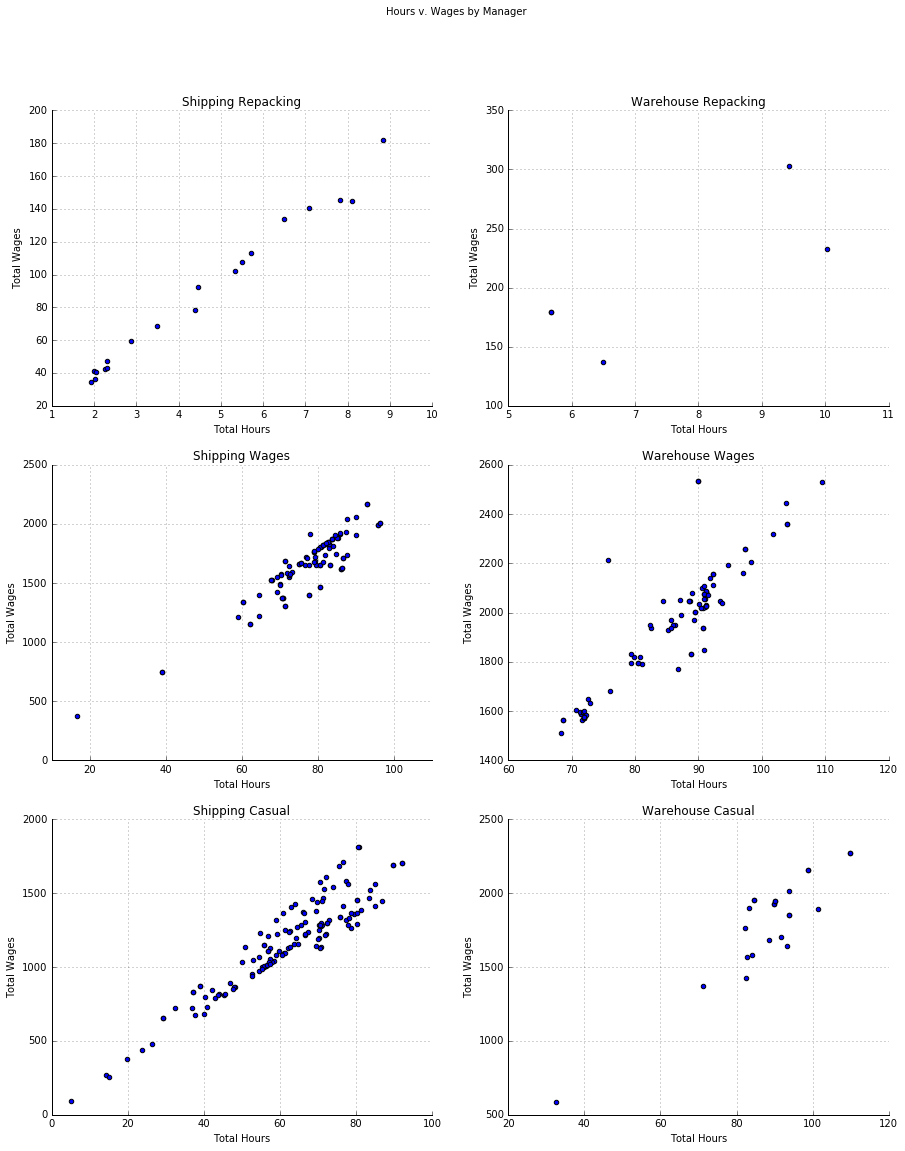

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil as roundup
%matplotlib inline

def plot_by_category(ops_df, category, x='total|hours', y='total|wages', 
                     sub_category='labor_level', suptitle=None, verbose=0):
    '''
    
    '''
    all_levels = ops_df[category].unique()
    n_levels = len(all_levels)
    
    if verbose:
        print('''
        There are {} levels in this category:
        {}
        '''.format(n_levels, all_levels))

    n_rows = roundup(n_levels/2)
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 6*n_rows))

    for i, level in enumerate(all_levels):
        _df = ops_df.loc[ops_df[category] == level]
        
        sub_category_rng = np.arange(0, len(sub_category))
        
        if i < n_rows:
            _df.plot(x, y, kind='scatter', ax=axes[i, 0])
            axes[i, 0].grid(alpha=.7)
            axes[i, 0].set_xlabel('Total Hours')
            axes[i, 0].set_ylabel('Total Wages')
            axes[i, 0].set_title(level)
        else:
            _df.plot(x='total|hours', y='total|wages', kind='scatter', ax=axes[i-n_rows, 1])
            axes[i-n_rows, 1].grid(alpha=.7)
            axes[i-n_rows, 1].set_xlabel('Total Hours')
            axes[i-n_rows, 1].set_ylabel('Total Wages')
            axes[i-n_rows, 1].set_title(level)
        sns.despine()
    if suptitle != None: plt.suptitle(suptitle)
    return None
        
plot_by_category(ops_df, category='labor_level', suptitle='Hours v. Wages by Manager')
#plot_by_category(ops_df, category='starting_date', suptitle='Hours v. Wages by Manager')